In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Load the training and test datasets
train_data_path = '/data/challenge2_files/mitomycinFulvestrantTrain.tsv'
test_data_path = '/data/testData.tsv'

train_df = pd.read_csv(train_data_path, sep='\t')
test_df = pd.read_csv(test_data_path, sep='\t')

# columns of interest from decision tree 
# Columns to include for modeling
columns_of_interest = ['rna_EFEMP2', 'rna_C16orf45', 'rna_CECR1', 'rna_IL23A', 'rna_POP7', 'rna_URB2', 'rna_PDCD6',
                         'rna_APAF1', 'rna_FAM21A', 'rna_S100A16', 'rna_LOC100505920', 'rna_RGL1', 'rna_AARSD1',
                         'rna_CAV1', 'rna_FOXJ2', 'rna_ANKMY1', 'rna_ATRAID', 'rna_TRAF4', 'rna_RSAD1', 'rna_SURF2',
                         'rna_TTC39A', 'rna_TSR3', 'rna_POLH', 'rna_H1F0']
target_column = 'Mitomycin-Fulvestrant_response'

# Ensure both dataframes have the same columns
common_columns = set(train_df.columns) & set(test_df.columns)
common_columns.discard(target_column)

# Keep only the common columns in both datasets
columns_of_interest = list(set(columns_of_interest).intersection(common_columns))

# Keep only the specified columns in both datasets
train_df = train_df[[target_column] + columns_of_interest]
test_df = test_df[columns_of_interest]

# Assuming 'Mitomycin-Fulvestrant_response' is the target column
features = [col for col in train_df.columns if col != target_column]

# Identify categorical columns
categorical_columns = train_df[features].select_dtypes(include=['object']).columns.tolist()

# Apply Box-Cox transformation to specified columns
power_transformer = PowerTransformer()
train_df[columns_of_interest[1:]] = power_transformer.fit_transform(train_df[columns_of_interest[1:]])
test_df[columns_of_interest[1:]] = power_transformer.transform(test_df[columns_of_interest[1:]])

# One-hot encode categorical columns using ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

# Apply one-hot encoding to training and test data
X_train_encoded = encoder.fit_transform(train_df[features])
X_test_encoded = encoder.transform(test_df)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_encoded)
X_test_std = scaler.transform(X_test_encoded)

# Upsample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_std, train_df[target_column])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Build a stack of Adaboost and Decision Tree classifiers
base_classifier = DecisionTreeClassifier(max_depth=2)
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the model
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = adaboost_classifier.predict(X_val)

# Print accuracy on the validation set
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")

# Make predictions on the test set
y_test_pred = adaboost_classifier.predict(X_test_std)

# Display the predictions and the updated test_df with row numbers
test_df['Mitomycin-Fulvestrant_response'] = y_test_pred
result_df = test_df[['Mitomycin-Fulvestrant_response']]
print(result_df)
a = result_df['Mitomycin-Fulvestrant_response'].tolist()

Validation Accuracy: 0.7272727272727273
                 Mitomycin-Fulvestrant_response
BrainCNS_VFF746                               1
Bowel_KI64                                    1
Bowel_QEVT62                                  0
Lung_TXY395                                   1
Lung_JIL5                                     1
Blood_CB485                                   1
Skin_SFL7                                     1
Skin_VAK5                                     1
Ovary_XT38                                    0


Validation Accuracy: 0.7272727272727273
Validation ROC-AUC: 0.7


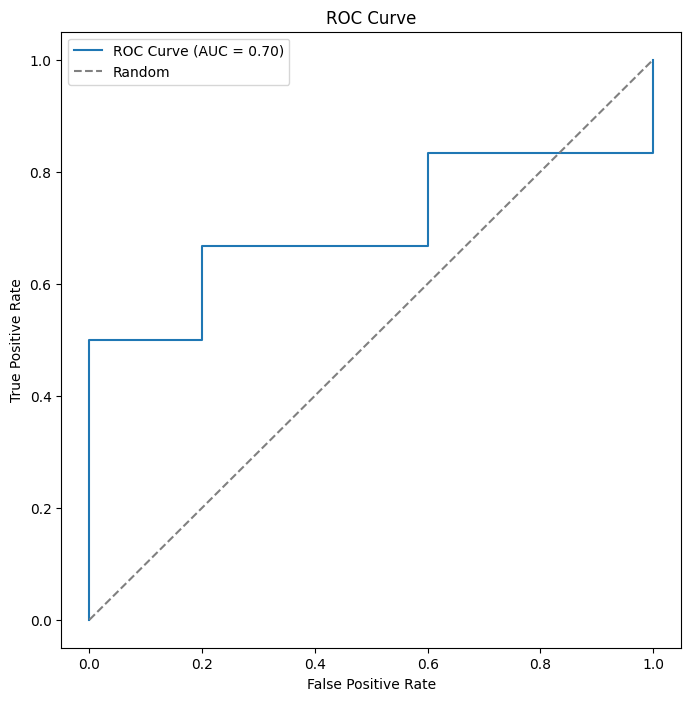

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Make predictions on the validation set
y_val_pred = adaboost_classifier.predict(X_val)

# Print accuracy and ROC-AUC on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# Calculate ROC-AUC on the validation set
y_val_proba = adaboost_classifier.predict_proba(X_val)[:, 1]  # Use the probability estimates for the positive class
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [32]:
import pandas as pd

# Load the existing CSV file
existing_file_path = '/results/Code_sharks_model_info.csv'
existing_df2 = pd.read_csv(existing_file_path)

# Values for the second column
fourth_column_values = ['Mitomycin-Fulvestrant_response.ipynb', 'stack of Adaboost and Decision Tree classifier', '72.7', '25', 'Tree important features', "'rna_EFEMP2', 'rna_C16orf45', 'rna_CECR1', 'rna_IL23A', 'rna_POP7', 'rna_URB2', 'rna_PDCD6','rna_APAF1', 'rna_FAM21A', 'rna_S100A16', 'rna_LOC100505920', 'rna_RGL1', 'rna_AARSD1','rna_CAV1', 'rna_FOXJ2', 'rna_ANKMY1', 'rna_ATRAID', 'rna_TRAF4', 'rna_RSAD1', 'rna_SURF2','rna_TTC39A', 'rna_TSR3', 'rna_POLH', 'rna_H1F0'", "'rna_EFEMP2', 'rna_C16orf45', 'rna_CECR1', 'rna_IL23A', 'rna_POP7', 'rna_URB2', 'rna_PDCD6','rna_APAF1', 'rna_FAM21A', 'rna_S100A16', 'rna_LOC100505920', 'rna_RGL1', 'rna_AARSD1','rna_CAV1', 'rna_FOXJ2', 'rna_ANKMY1', 'rna_ATRAID', 'rna_TRAF4', 'rna_RSAD1', 'rna_SURF2','rna_TTC39A', 'rna_TSR3', 'rna_POLH', 'rna_H1F0'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'", "'rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1'"]

# Add the second column to the DataFrame
existing_df2['Mitomycin-Fulvestrant_response'] = fourth_column_values

# Save the updated DataFrame to the same CSV file
existing_df2.to_csv(existing_file_path, index=False)

# Display the updated DataFrame
print(existing_df2)


                   Unnamed: 0  \
0                    Filename   
1              Algorithm used   
2           Training accuracy   
3          Number of Features   
4   Feature evaluation method   
5         Overall key feature   
6          Breast key feature   
7        BrainCNS key feature   
8           Bowel key feature   
9           Blood key feature   
10           Skin key feature   
11           Lung key feature   
12          Ovary key feature   
13       Prostate key feature   
14         Kidney key feature   

                                 Fulvestrant_response  \
0                          Fulvestrant_response.ipynb   
1                                    sklearn_adaboost   
2                                                  95   
3                                                  30   
4                                  Mutual Index score   
5   'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...   
6   'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...   
7   'rna_LOC100

In [27]:
existing_df2

,Unnamed: 0,Fulvestrant_response,Fulvestrant_response_features
0,Breast key feature,0,rna_LOC100505938
1,BrainCNS key feature,0,rna_LOC100505938
2,Bowel key feature,0,rna_LOC100505938
3,Blood key feature,0,rna_LOC100505938
4,Skin key feature,1,rna_LOC100505938
5,Lung key feature,0,rna_LOC100505938
6,Ovary key feature,0,rna_LOC100505938
7,Prostate key feature,0,rna_LOC100505938
8,Kidney key feature,0,rna_LOC100505938


In [29]:
# Get feature importances for each sample in the test set
feature_names_per_sample = []

for i, sample in enumerate(X_test_std):
    # Get feature importances for the current sample
    sample_importances = adaboost_classifier.feature_importances_
    
    # Get the indices of the top features (adjust n_top_features as needed)
    n_top_features = 5  # Adjust this number to get the top N features
    top_feature_indices = sample_importances.argsort()[-n_top_features:][::-1]
    
    # Get the feature names for the top features
    top_feature_names = [features[idx] for idx in top_feature_indices]
    
    # Store the top feature names in a list
    feature_names_per_sample.append({'SampleIndex': i, 'TopFeatures': top_feature_names})

# Display the list of top feature names for each sample
for sample_info in feature_names_per_sample:
    print(f"Sample {sample_info['SampleIndex']} Top Features:")
    print(sample_info['TopFeatures'])
    print("\n")


Sample 0 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 1 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 2 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 3 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 4 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 5 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 6 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 7 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']


Sample 8 Top Features:
['rna_SURF2', 'rna_S100A16', 'rna_TSR3', 'rna_AARSD1', 'rna_CECR1']




In [30]:
import pandas as pd

# Load the existing CSV file
existing_file_path = '/results/CodeSharks_model_output.csv'
existing_df = pd.read_csv(existing_file_path)

# Add two additional columns without overwriting existing ones
existing_df['Mitomycin-Fulvestrant_response'] = a
existing_df['Mitomycin-Fulvestrant_response_features'] = 'rna_SURF2'

# Save the updated DataFrame to the same CSV file
existing_df.to_csv(existing_file_path, index=False)

# Display the updated DataFrame
print(existing_df)


             Unnamed: 0  Fulvestrant_response Fulvestrant_response_features  \
0    Breast key feature                     0              rna_LOC100505938   
1  BrainCNS key feature                     0              rna_LOC100505938   
2     Bowel key feature                     0              rna_LOC100505938   
3     Blood key feature                     0              rna_LOC100505938   
4      Skin key feature                     1              rna_LOC100505938   
5      Lung key feature                     0              rna_LOC100505938   
6     Ovary key feature                     0              rna_LOC100505938   
7  Prostate key feature                     0              rna_LOC100505938   
8    Kidney key feature                     0              rna_LOC100505938   

   Gefitinib_response Gefitinib_response_features  Mitomycin_response  \
0                   0                 rna_B3GALT1                   1   
1                   0                 rna_B3GALT1              

In [31]:
existing_df

,Unnamed: 0,Fulvestrant_response,Fulvestrant_response_features,Gefitinib_response,Gefitinib_response_features,Mitomycin_response,Mitomycin_response_features,Mitomycin-Fulvestrant_response,Mitomycin-Fulvestrant_response_features,Rapamycin-Gefitinib_response,Rapamycin-Gefitini_features,Rapamycin_response,Rapamycin_response_features
0,Breast key feature,0,rna_LOC100505938,0,rna_B3GALT1,1,rna_ENTPD5,1,rna_SURF2,1,rna_PLEKHA3,1,rna_ADAMTS1
1,BrainCNS key feature,0,rna_LOC100505938,0,rna_B3GALT1,1,rna_ENTPD5,1,rna_SURF2,1,rna_PLEKHA3,0,rna_ADAMTS1
2,Bowel key feature,0,rna_LOC100505938,0,rna_B3GALT1,1,rna_ENTPD5,0,rna_SURF2,0,rna_PLEKHA3,0,rna_ADAMTS1
3,Blood key feature,0,rna_LOC100505938,1,rna_B3GALT1,0,rna_ENTPD5,1,rna_SURF2,0,rna_PLEKHA3,1,rna_ADAMTS1
4,Skin key feature,1,rna_LOC100505938,1,rna_B3GALT1,1,rna_ENTPD5,1,rna_SURF2,1,rna_PLEKHA3,0,rna_ADAMTS1
5,Lung key feature,0,rna_LOC100505938,0,rna_B3GALT1,1,rna_ENTPD5,1,rna_SURF2,1,rna_PLEKHA3,1,rna_ADAMTS1
6,Ovary key feature,0,rna_LOC100505938,0,rna_B3GALT1,0,rna_ENTPD5,1,rna_SURF2,1,rna_PLEKHA3,0,rna_ADAMTS1
7,Prostate key feature,0,rna_LOC100505938,1,rna_B3GALT1,0,rna_ENTPD5,1,rna_SURF2,0,rna_PLEKHA3,0,rna_ADAMTS1
8,Kidney key feature,0,rna_LOC100505938,0,rna_B3GALT1,0,rna_ENTPD5,0,rna_SURF2,1,rna_PLEKHA3,1,rna_ADAMTS1
